In [1]:
import numpy as np
import pandas as pd

# the Bayesian stuff
import bambi as bmb
import pymc as pm

# plotting
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# RNG
rng = np.random.default_rng(seed=20240704)

## Example 3: Modeling air and soil temperatures on Svalbard

Let's move on to an example with real data (finally!).

We will use a station data from the Bayelva station near Ny-Ålesund, Svalbard ([Boike et al. 2018](https://essd.copernicus.org/articles/10/355/2018/)).

The data provided here are a subset of the meterological and soil variables for the years 1999-2022.

In [2]:
import os.path, requests

datafile = os.path.join("..", "data", "Bayelva_LTO_lv2_1999-2022.csv")
# download file if not available
if not os.path.isfile(datafile):
    r = requests.get("https://nextcloud.awi.de/s/Rg2krRSg8Y42kND/download/Bayelva_LTO_lv2_1999-2022.csv", stream=True)
    with open(datafile, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
bayelva_dataset = pd.read_csv(datafile)
bayelva_dataset["UTC"] = pd.to_datetime(bayelva_dataset["UTC"])
bayelva_dataset = bayelva_dataset.set_index("UTC")
bayelva_dataset.describe()

,Tair_degC_200cm,RH_percent_200cm,prec_mm/hour,snowdepth_m,RadNet_W/m2,Tsoil_degC_3cm,VWC_m3/m3_3cm
count,199790.000000,185380.000000,195219.000000,176959.000000,199021.000000,198740.000000,176026.000000
mean,-4.217781,79.798462,0.034956,0.418416,4.977135,-1.334803,0.106777
std,8.484430,11.532096,0.245242,0.360099,65.514785,5.502911,0.076466
min,-33.385000,34.070000,0.000000,-0.091000,-294.550000,-18.382000,-0.005000
25%,-10.346000,71.780000,0.000000,0.023000,-34.480000,-4.776000,0.059700
50%,-2.868500,80.090000,0.000000,0.410000,-6.900000,-1.586000,0.074900
75%,2.653750,88.330000,0.000000,0.713000,17.310000,0.476000,0.147000
max,17.565000,101.860000,23.100000,1.563000,529.670000,20.500000,0.444600


We'll start with a simple trend analysis. First we resample the data to annual scale.

In [4]:
# apply sum for precipitation but mean for everything else
agg_ops = {c: "sum" if c.startswith('prec') else "mean" for c in bayelva_dataset.columns}
bayelva_dataset_annual = bayelva_dataset.resample("1YE").agg(agg_ops)
# rename columns for convenience
bayelva_dataset_annual = bayelva_dataset_annual.rename({"Tair_degC_200cm": "Tair", "Tsoil_degC_3cm": "Tsoil"}, axis=1)
# drop years with a large number of missing data points;
# this is for example purposes only, see Grünberg et al. 2024 for a more thorough analysis.
bayelva_dataset_annual[bayelva_dataset.resample("1YE").count() < 335*24] = np.nan
# then add years as a covariate
bayelva_dataset_annual["year"] = bayelva_dataset_annual.index.year

Now let's specify the model using [bambi](https://bambinos.github.io/bambi/), a convenient wrapper around pymc that simplifies the specification of linear models.

In [5]:
Tair_trend_model = bmb.Model("Tair ~ 1 + year", bayelva_dataset_annual, family="t")

The basic model specification syntax is similar to other tools in python and R.

`1 + year` indicates a constant intercept plus a linear effect on the year.

We choose the likelihood to be a t-distribution with `family="t"` to make the trend analysis more robust to outliers.

Sampling: [Intercept, Tair_nu, Tair_sigma, year]


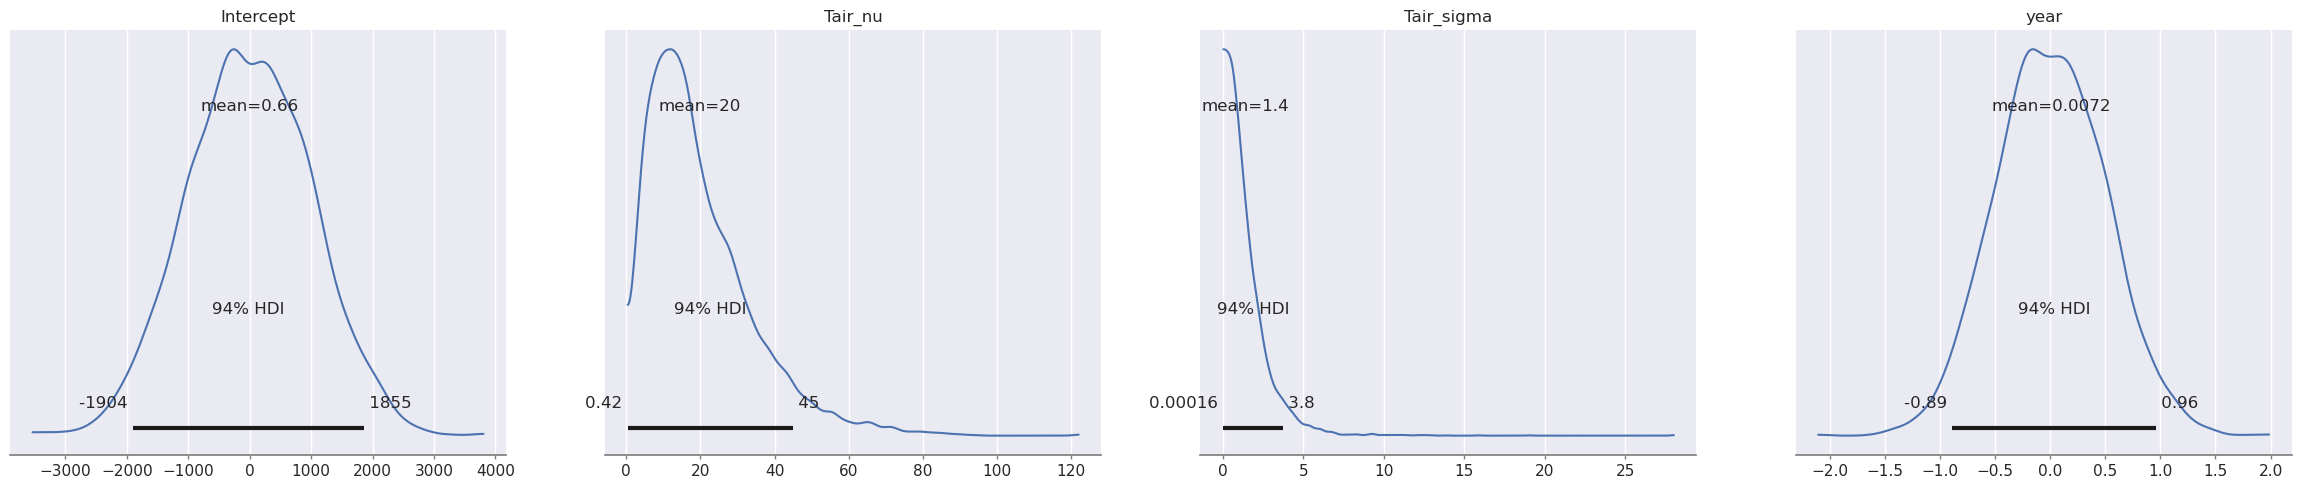

In [6]:
# we can also plot the priors 
Tair_trend_model.build()
Tair_trend_model.plot_priors();

Now we can fit the model. Like pymc, bambi defaults to using NUTS for inference.

In [7]:
trend_idata = Tair_trend_model.fit(draws=1000, random_seed=1234)
az.summary(trend_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tair_nu, Tair_sigma, Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-166.155,77.964,-319.165,-25.465,1.367,0.971,3291.0,2411.0,1.0
Tair_nu,18.297,13.458,1.365,42.593,0.238,0.169,2576.0,2492.0,1.0
Tair_sigma,1.240,0.239,0.831,1.736,0.005,0.003,2559.0,2134.0,1.0
year,0.081,0.039,0.011,0.157,0.001,0.000,3294.0,2405.0,1.0


In [8]:
print("{}% prob. that the trend > 0".format((trend_idata.posterior.year > 0.0).mean().values*100))

97.82499999999999% prob. that the trend > 0


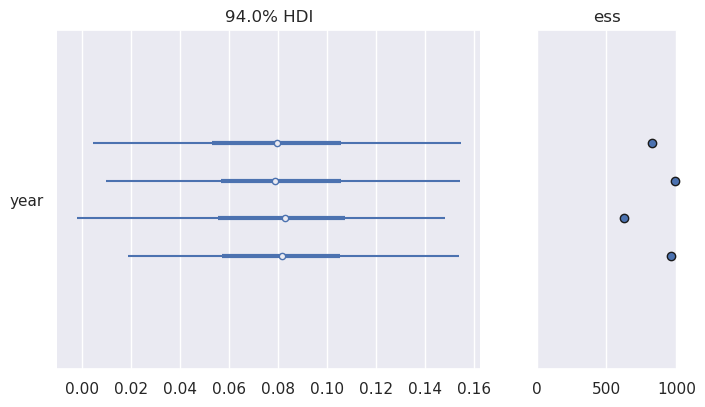

In [9]:
az.plot_forest(trend_idata, var_names=["year"], ess=True);

We can also visualize the predicted trend line.

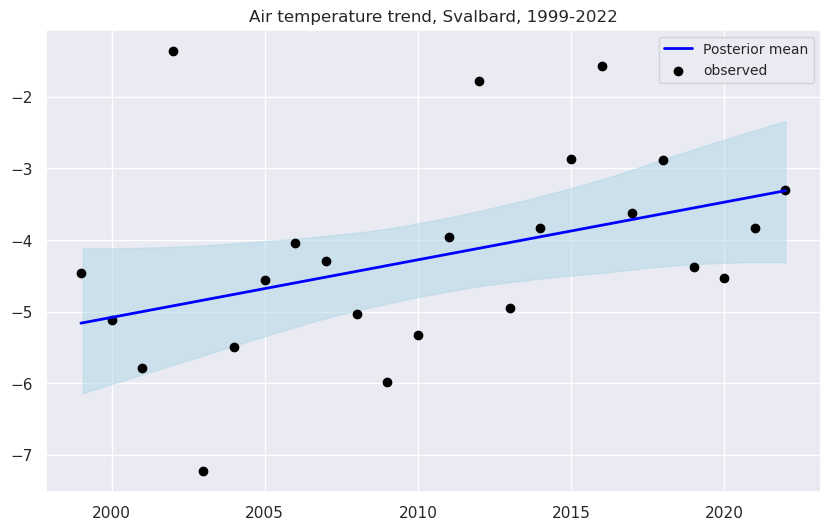

In [19]:
Tair_trend_model.predict(trend_idata, kind="pps")
ax = az.plot_hdi(x=bayelva_dataset_annual.year, y=trend_idata.posterior.Tair_mean,
                 color="lightblue", figsize=(10,6))
# ax.plot(bayelva_dataset_annual.year, trend_idata.posterior.Tair_mean.stack(samples=["chain","draw"]),
#         linewidth=1.0, color="lightblue", alpha=0.4)
ax.plot(bayelva_dataset_annual.year, trend_idata.posterior.Tair_mean.mean(dim=["chain","draw"]),
        linewidth=2.0, color="blue", label="Posterior mean")
ax.scatter(bayelva_dataset_annual.year, bayelva_dataset_annual.Tair, color="black", label="observed")
plt.legend(loc='best', prop={'size': 10})
plt.title("Air temperature trend, Svalbard, 1999-2022")
plt.show()

Now suppose we want to investigate the relationship between soil and air temperature.

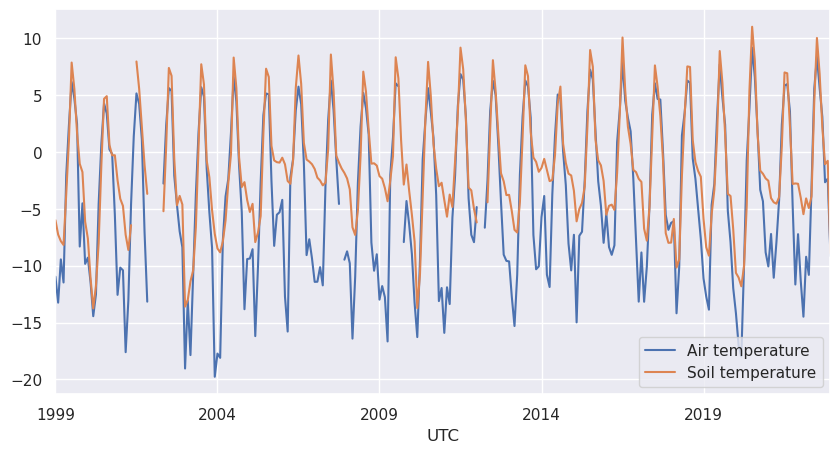

In [11]:
bayelva_dataset_monthly = bayelva_dataset.resample("1ME").agg(agg_ops) \
    .rename({"Tair_degC_200cm": "Tair", "Tsoil_degC_3cm": "Tsoil"}, axis=1)

plt.figure(figsize=(10,5))
bayelva_dataset_monthly.Tair.plot(label="Air temperature")
bayelva_dataset_monthly.Tsoil.plot(label="Soil temperature")
plt.legend(loc="lower right")
plt.show()

It's clear that soil temperature is very closely related to air temperature in the summer but becomes decoupled in the winter. We know that this should be mostly due to snow cover.

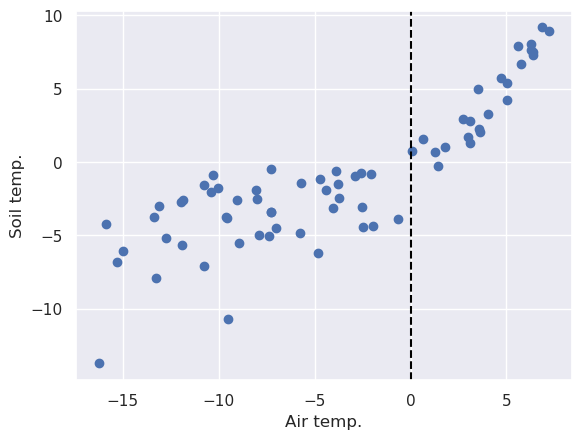

In [12]:
# select 2010-2015 as training period
bayelva_train = bayelva_dataset_monthly["2010":"2015"]
# get indices where both Tair and Tsoil are not missing
na_mask = ~bayelva_train.Tair.isna()*~bayelva_train.Tsoil.isna()
plt.scatter(bayelva_train.Tair.loc[na_mask], bayelva_train.Tsoil.loc[na_mask]);
plt.axvline([0.0], color="black", linestyle="--")
plt.xlabel("Air temp.")
plt.ylabel("Soil temp.");

It's clear that there is a clear change in the relationship around zero degrees.

Bearing this in mind, let's add a binary variable `is_freezing` that is true whenever air temperature is less than or equal to zero.

In [13]:
bayelva_train["is_freezing"] = bayelva_train.Tair <= 0

/tmp/ipykernel_351814/2663611640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayelva_train["is_freezing"] = bayelva_train.Tair <= 0


Now we can try to build a model.

The `(Tair|is_freezing)` syntax specifies a *group effect*. This will create separate regression coefficients for the two groups `is_freezing` and its negation.

In [14]:
model_Tsoil_Tair = bmb.Model("Tsoil ~ 1 + (Tair|is_freezing)", bayelva_train.loc[na_mask], family="t")
model_Tsoil_Tair

       Formula: Tsoil ~ 1 + (Tair|is_freezing)
        Family: t
          Link: mu = identity
  Observations: 69
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.946, sigma: 11.8058)
        
        Group-level effects
            1|is_freezing ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 11.8058))
            Tair|is_freezing ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.7318))
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
            sigma ~ HalfStudentT(nu: 4.0, sigma: 4.7223)

Now let's fit the model.

In [15]:
idata = model_Tsoil_Tair.fit(draws=1000, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tsoil_nu, Tsoil_sigma, Intercept, 1|is_freezing_sigma, 1|is_freezing_offset, Tair|is_freezing_sigma, Tair|is_freezing_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Always pay attention to the warnings from the sampler! The high number of divergences is a problem and indicates a potential problem with our model, or we may need to tweak the sampler settings.

In [16]:
# note that low ESS and high r_hat is a sign of poor convergence
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|is_freezing[False],0.183,1.778,-3.698,4.172,0.211,0.193,108.0,30.0,1.04
1|is_freezing[True],-0.174,1.720,-3.416,4.293,0.203,0.144,98.0,28.0,1.03
1|is_freezing_sigma,2.515,2.495,0.000,7.051,0.138,0.102,416.0,457.0,1.01
Intercept,-1.311,1.772,-4.928,2.675,0.207,0.195,100.0,36.0,1.03
Tair|is_freezing[False],1.336,0.165,1.005,1.631,0.005,0.003,1343.0,2234.0,1.00
Tair|is_freezing[True],0.248,0.071,0.116,0.381,0.002,0.001,1324.0,1666.0,1.00
Tair|is_freezing_sigma,1.376,0.662,0.370,2.556,0.027,0.019,502.0,596.0,1.00
Tsoil_nu,13.000,10.334,2.227,32.687,0.917,0.664,228.0,199.0,1.02
Tsoil_sigma,1.731,0.217,1.310,2.121,0.007,0.005,1040.0,1600.0,1.00


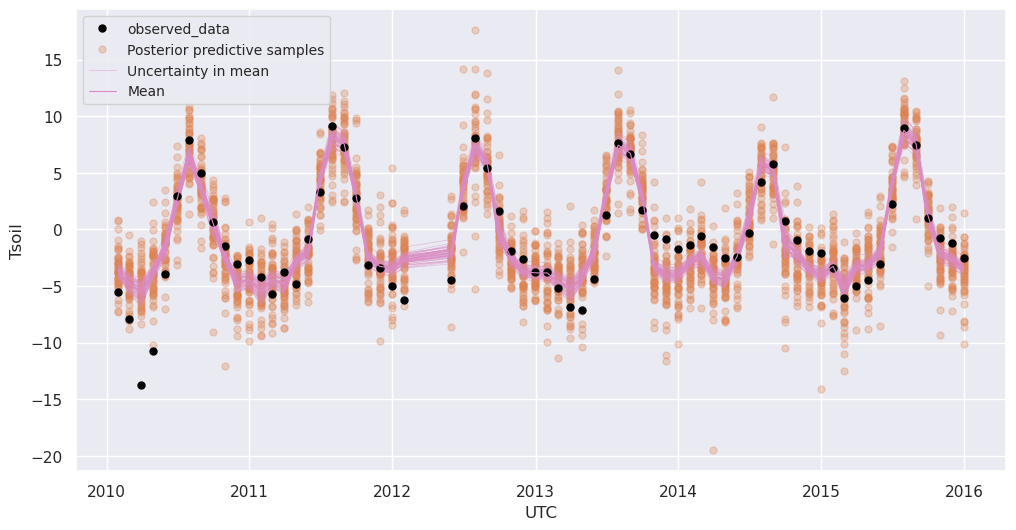

In [17]:
# generate predictions and plot them
model_Tsoil_Tair.predict(idata, kind="pps")
az.plot_lm(x=bayelva_train.loc[na_mask].index, y="Tsoil", idata=idata, y_hat="Tsoil", y_model="Tsoil_mean",
           figsize=(12,6), y_kwargs={'color': 'black', 'markersize': 10})
plt.legend(loc="best", prop={'size': 10});

There indeed seem to be some systematic issues with our model. We are not able to capture the cold anomalies in winter of 2010 or the warm winter of 2014.

Note also the data gap in 2012!

#### Exercises

1. How do you think we can improve this model? So far we have only used air and soil temperature, but perhaps you can find a way to use some of the other variables such as snow depth, precipitation, and radiation?

2. Try implementing an autoregressive version of this model using pymc's `AR` distribution. You could refer to [this example](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html) as a starting point.